# HW7: HMM


**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Winter, 2021._

---

**Name:** Jake Taylor

**Names of any collaborators:** _Names here_

*Due: 11:59pm Monday, May 24, 2021 via GradeScope*

---

In this homework we will learn how to fit a Hidden Markov Model. See the slides for Lap 7 ([Part 1](https://github.com/slinderman/stats271sp2021/blob/main/slides/lap7_hmms.pdf) and [Part 2](https://github.com/slinderman/stats271sp2021/blob/main/slides/lap7_hmms_b.pdf)) for more information on this model.

The data set we will be working with consists of player position data from a 2015-2016 NBA game between the Golden State Warriors and the Cleveland Cavaliers. This game will be broken into a couple hundred "events" (continuous plays in the game), and we will model this as a 20-dimensional HMM (the $x,y$ co-ordinates of the 10 players), where each event is a conditionally independent realization of the HMM. For simplicity, we will ignore the position of the ball and ignore plays that include inbounding (when there are only 9 players on the court).

Mathematically, let $\mathbf{x}_t^{(v)} \in \mathbb{R}^{20}$ denote the combined positions of all 10 players at time step $t$ of the $i$-th event, and let $\mathbf{x}_{1:T_i}^{(i)} = (\mathbf{x}_1^{(v)}, \ldots, \mathbf{x}_{T_v}^{(v)})$ denote the full sequence of positions for the $v$-th event, where $T_v$ is the number of time frames. Likewise, let $z_{1:T_v}^{(v)} = (z_1^{(v)}, \ldots, z_{T_v}^{(v)})$ denote the sequence of discrete states for the $i$-th event. 
We've downsampled the data to about 1.5fps or 0.66sec/time frame. 

The joint distribution of the complete dataset is,
\begin{align}
p(\{(z_{1:T_v}^{(v)}, \mathbf{x}_{1:T_v}^{(v)}\}_{v=1}^V \mid \Theta) 
&= \prod_{v=1}^V p(z_{1:T_v}^{(v)}, \mathbf{x}_{1:T_v}^{(v)} \mid \Theta) \\
&= \prod_{v=1}^V \left[p(z_1^{(v)} \mid \Theta) \prod_{t=2}^{T_v} p(z_{t}^{(v)} \mid z_{t-1}^{(v)} , \Theta)  \prod_{t=1}^{T_v} p(\mathbf{x}_{t}^{(v)} \mid z_{t}^{(v)}, \Theta) \right]
\end{align}
Your goal is to find the parameters $\Theta$ that maximize the marginal likelihood of the data by using EM. Then you'll use cross validation, holding out a random subset of events, to determine the number of discrete states. Finally, you'll visualize the inferred states in terms of the distribution over each player's location on the court.

**Note**: We've provided the data in both a numpy array and a CSV file. The first column of the CSV file includes the event index and the remaining columns include the player positions.

In [4]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt

event_data = np.load('event_data.npy', allow_pickle = True)
print(event_data.shape)
event_data = list(event_data)

print("number of events: ", len(event_data))
print("average event length: ", np.mean([len(xs) for xs in event_data]))
print("total number of time steps", np.sum([len(xs) for xs in event_data]))

(260,)
number of events:  260
average event length:  16.515384615384615
total number of time steps 4294


# Part 1: Fit a HMM to the model

## Problem 1a: Implement EM for a Gaussian HMM
To get you started, we've provided a few function headers that you might find helpful.

**Note:** To keep it simple, you can assume a fixed, uniform initial distribution and a fixed transition matrix of the form \begin{align}
P_{ij} &= \begin{cases}
1-\epsilon & \text{if } i=j \\
\frac{\epsilon}{K-1} & \text{o.w.}
\end{cases}
\end{align}
for small-ish $\epsilon$.

In [53]:
class HiddenMarkovModel:
    def __init__(self, num_states, epsilon=0.01):
        self.epsilon = epsilon
        self.num_states = num_states
        self.initial_distribution = np.ones(self.num_states) / self.num_states
        self.transition_matrix = np.diag(np.ones(self.num_states))
        self.transition_matrix = np.where(self.transition_matrix == 0,
                                          (epsilon / (self.num_states - 1)),
                                          1 - self.epsilon)
        self.normals = {}
        self.data = None
        self.events = None
        self.marginals = []

    def forward_pass(self, log_likelihoods):
        """Perform the forward pass and return the forward messages for
        a single "event".

        In the descriptions below, let K denote the number of discrete states
        and T the number of time steps.

        Parameters
        ---
        initial_dist: (K,) array with initial state probabilities
        transition_matrix: (K, K) array where each row is a transition probability
        log_likelihoods: (T, K) array with entries log p(x_t | z_t=k)

        Returns
        ---
        alphas: (T, K) array of forward messages
        marginal_ll: real-valued scalar, log p(x_{1:T})
        """
        # alpha.shape => (K,)
        alphas = [self.initial_distribution]
        likelihoods = np.exp(log_likelihoods)
        marginal_ll = 0
        try:
            T, K = log_likelihoods.shape
        except:
            K = len(log_likelihoods)
            T = 1
            A = alphas[0].dot(likelihoods)
            alpha = (1 / A) * self.transition_matrix.T.dot(alphas[0] * likelihoods)
            return alpha.reshape(T, K), np.log(A)
        for t in range(T - 1):
            # normalize for numerical stability
            A = alphas[t].dot(likelihoods[t, :])
            marginal_ll += np.log(A)
            # (K, K) dot ((K,) * (K,))
            alphas.append((1 / A) * self.transition_matrix.T.dot(alphas[t] * likelihoods[t, :]))
        alphas = np.vstack(alphas)
        assert alphas.shape == (T, K)
        return alphas, marginal_ll

    def backward_pass(self, log_likelihoods):
        """Perform the backward pass and return the backward messages for
        a single "event".

        Parameters
        ---
        transition_matrix: (K, K) array where each row is a transition probability
        log_likelihoods: (T, K) array with entries log p(x_t | z_t=k)

        Returns
        ---
        betas: (T, K) array of backward messages
        """
        likelihoods = np.exp(log_likelihoods)
        try:
            T, K = log_likelihoods.shape
        except:
            K = len(log_likelihoods)
            T = 1
            B = np.ones(K).dot(likelihoods)
            beta = ((1 / B) * self.transition_matrix.dot(np.ones(K) * likelihoods))
            return beta.reshape(T, K)
        betas = [1] * T
        # beta.shape => (K,)
        betas[T - 1] = np.ones(K)
        for t in range(T - 1, -1, -1):
            # normalize for numerical stability
            B = betas[t].dot(likelihoods[t, :])
            # (K, K) dot ((K,) * (K,))
            betas[t - 1] = ((1 / B) * self.transition_matrix.dot(betas[t] * likelihoods[t, :]))
        betas = np.vstack(betas)
        assert betas.shape == (T, K)
        return betas

    def e_step(self):
        """Run the E step for each event. First compute the log likelihoods
        for each time step and discrete state using the given data and parameters.
        Then run the forward and backward passes and use the output to compute the
        posterior marginals, and use marginal_ll to compute the marginal likelihood.

        Parameters
        ---
        data: list of (T, 20) arrays with player positions over time for each event
        parameters: a data structure containing the model parameters; i.e. the
            initial distribution, transition matrix, and Gaussian means and
            covariances.

        Returns
        ---
        expectations: list of (T, K) arrays of marginal probabilities
            p(z_t = k | x_{1:T}) for each event.
        marginal_ll: marginal log probability p(x_{1:T}). This should go up
            each iteration!
        """
        expectations = []
        marginal_ll = 0
        # Run an E-step for each event
        for event in range(self.events):
            temp_data = self.data[event]
            T, K = temp_data.shape
            # compute log likelihoods for each time step
            # from the initialized parameters
            # log_likelihoods: (T, K) array with entries log p(x_t | z_t=k)
            log_likelihoods = []
            for normal in self.normals:
                log_likelihoods.append(self.normals[normal].logpdf(temp_data)[..., None])
            log_likelihoods = np.hstack(log_likelihoods)
            alphas, temp_marginal_ll = self.forward_pass(log_likelihoods)
            # Sum conditionally independent "events"
            marginal_ll += temp_marginal_ll
            betas = self.backward_pass(log_likelihoods)
            # compute expectations
            likelihoods = np.exp(log_likelihoods)
            temp = alphas * likelihoods * betas
            expectation = temp / (np.sum(temp, axis=1)[..., None])
            #assert expectation.shape == (T, K)
            expectations.append(expectation)
        assert len(expectations) == len(self.data)
        return expectations, marginal_ll
    def m_step(self, expectations):
        """Solve for the Gaussian parameters that maximize the expected log
        likelihood.

        Note: you can assume fixed initial distribution and transition matrix as
        described in the markdown above.

        Parameters
        ----------
        data: list of (T, 20) arrays with player positions over time for each event
        expectations: list of (T, K) arrays with marginal state probabilities from
            the E step.

        Returns
        -------
        parameters: a data structure containing the model parameters; i.e. the
            initial distribution, transition matrix, and Gaussian means and
            covariances.
        """
        # Consolidate all timesteps into one set of parameters
        self.normals = {}
        total_data = np.concatenate(self.data)
        total_expectations = np.concatenate(expectations)
        if np.sum(np.where(total_expectations==0)) > 0:
            # add small numerical stability if needed
           total_expectations += 1e-5
        for i in range(self.num_states):
            weights = total_expectations[:, i, None]
            psi_k_2 = (weights * total_data).sum(axis=0)
            psi_k_1 = (weights * total_data).T @ total_data
            psi_k_3 = np.sum(weights)
            bk = psi_k_2 / psi_k_3
            Qk = (1 / psi_k_3) * (
                psi_k_1
                - psi_k_2[..., None] @ psi_k_2[..., None].T
                / psi_k_3
            )
            self.normals[i] = multivariate_normal(mean=bk, cov=Qk)

    def init_params(self):
      """Initialize clusters randomly to generate parameters"""
      total_data = np.concatenate(self.data)
      self.total_steps = len(total_data)
      labels = np.random.randint(low=0, high=self.num_states, size=len(total_data))
      #labels = np.array(list(range(0, self.num_states)) * int(np.ceil(len(total_data) / self.num_states)))[:len(total_data)]
      for i in range(self.num_states):
          temp = total_data[labels == i]
          bk = np.mean(temp, axis=0)
          Qk = (1 / len(temp)) * (
                  (temp.T @ temp)
                  - (temp.sum(axis=0)[..., None] @ temp.sum(axis=0)[..., None].T)
                  / len(temp)
          )
          self.normals[i] = multivariate_normal(mean=bk, cov=Qk)
        
    def marginal_likelihood(self, data):
        """Compute marginal log-likelihood on dataset"""
        if isinstance(data, list):
            events = len(data)
        else:
            events = 1
        marginal_ll = 0
        # Run an E-step for each event
        for event in range(events):
            if events != 1:
                temp_data = data[event]
            else:
                temp_data = data
            T, K = temp_data.shape
            # compute log likelihoods for each time step
            # from the initialized parameters
            # log_likelihoods: (T, K) array with entries log p(x_t | z_t=k)
            log_likelihoods = []
            for normal in self.normals:
                log_likelihoods.append(self.normals[normal].logpdf(temp_data)[..., None])
            log_likelihoods = np.hstack(log_likelihoods)
            alphas, temp_marginal_ll = self.forward_pass(log_likelihoods)
            # Sum conditionally independent "events"
            marginal_ll += temp_marginal_ll
        return marginal_ll

    def fit_hmm(self, data):
        """Fit an HMM using the EM algorithm above. You'll have to initialize the
        parameters somehow; k-means often works well. You'll also need to monitor
        the marginal likelihood and check for convergence.

        Returns
        -------
        lls: the marginal log likelihood over EM iterations
        parameters: the final parameters
        """
        self.data = data
        self.events = len(self.data)
        # combine all data and apply k-means clustering for inital params
        self.init_params()
        self.marginals = []
        i = 0
        threshold = np.inf
        while threshold > 0.1:
            expectations, marginal_ll = self.e_step()
            self.marginals.append(marginal_ll)
            if len(self.marginals) > 1:
                threshold = self.marginals[-1] - self.marginals[-2]
            self.m_step(expectations)
            print(f"{i}:{marginal_ll}")
            i += 1
        return self.normals

\pagebreak

## Problem 1b: Cross-validation
Holding out 20% of the events, use cross-validation to determine the optimal number of latent states to use. Plot held-out likelihood vs number of states. For simplicity/time saving purposes, train and cross-validate your model using $[10,20,30,40,50]$ hidden states.


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
train, test = train_test_split(event_data, test_size=0.2)

In [55]:
marginals = []
for num_states in [10, 20, 30, 40, 50]:
  print(f'Starting state {num_states}')
  hmm = HiddenMarkovModel(num_states=num_states, epsilon=.05)
  hmm.fit_hmm(train)
  marginal = hmm.marginal_likelihood(test)
  marginals.append(marginal)

Starting state 10
0:-251199.42800756983
1:-239884.9164964905
2:-236082.61833266472
3:-235511.45496352747
4:-235260.49733920768
5:-235132.620915282
6:-235001.1992085813
7:-234900.6639944566
8:-234815.11100012079
9:-234758.56511907725
10:-234732.02598757733
11:-234701.28761301198
12:-234677.7296280045
13:-234647.24313665976
14:-234611.52341744138
15:-234571.5364406405
16:-234546.99015365646
17:-234535.38675440275
18:-234528.4907932668
19:-234524.1827303157
20:-234513.54238750378
21:-234484.55793580075
22:-234468.8278057356
23:-234453.70528419717
24:-234424.62925893016
25:-234402.419305839
26:-234367.09597850667
27:-234337.51978205645
28:-234317.9924976973
29:-234300.81639019295
30:-234285.20825140475
31:-234260.14302496135
32:-234206.0401219578
33:-234180.6616812071
34:-234168.5178072753
35:-234156.38832841982
36:-234133.64472193603
37:-234131.61078459673
38:-234129.77791564065
39:-234125.6326977896
40:-234118.9218931213
41:-234108.63310706988
42:-234107.01113452305
43:-234102.9990835076

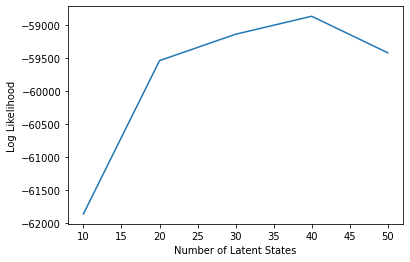

In [56]:
plt.plot([10, 20, 30, 40, 50], marginals)
plt.xlabel('Number of Latent States')
plt.ylabel('Log Likelihood')
plt.show()

\pagebreak

# Part 2: State visualization

Using the model selected from cross-validation, plot the player location distributions for a few states.

Specifically, let $b_k \in \mathbb{R}^{20}$ and $Q_k \in \mathbb{R}^{20 \times 20}$ denote the estimated mean and covariance of state $k$. From this, you can compute the mean location of each player by reshaping $b_k$ into a 10x2 array (one row per player). Likewise, you can compute the marginal covariance of that player's location by extracting the corresponding 2x2 diagonal block from $Q_k$. 

Overlay Gaussian contours for the locations of the 10 players on the basketball court, using the provided `court.png` file as the background. For an accurate portrayal of the positions, set `extent = [0,100,0,50]` so that the image has the same `x` and `y` limits as the data. If you're using python, you can use the following starter code to get yourself started.

Plot this for a few states. Some might look more interesting than others.

In [58]:
# 40 selected through CV
hmm = HiddenMarkovModel(num_states=40)
normals = hmm.fit_hmm(event_data)

0:-310909.4457021806
1:-269158.62787761167
2:-249715.98341118242
3:-247345.43158022218
4:-246951.50142178193
5:-246681.56674404297
6:-246450.34072532394
7:-246389.64389409768
8:-246354.71709030445
9:-246352.18275590226
10:-246341.93505411368
11:-246340.84502937208
12:-246328.8856148183
13:-246324.47773503503
14:-246324.47775945815


In [128]:
def covariance_overlay(mean, cov, width=2):
  mean = mean.reshape(10, 2)
  tr = np.diag(cov, k=1)
  bl = np.diag(cov, k=-1)
  mid = np.diag(cov)
  j=0
  for i in range(0, len(bl), 2):
    temp_mean = mean[j,:]
    x, y = np.mgrid[temp_mean[0]-width:temp_mean[0] + width:1,
                    temp_mean[1]-width:temp_mean[1]+width:1]
    
    pos = np.dstack((x, y))
    cov = np.array([[mid[i], tr[i]], [bl[i], mid[i+1]]])
    rv = multivariate_normal(mean=temp_mean, cov=cov)
    plt.contour(x, y, rv.pdf(pos), 1, zorder=1, alpha=.4, colors='black', linestyles='--')
    j+=1

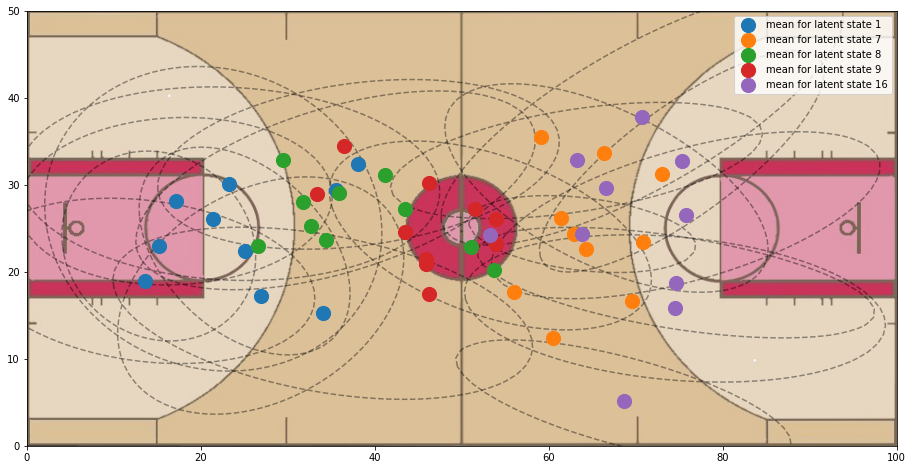

In [130]:
import matplotlib.pyplot as plt
img = plt.imread('court.png')
fig, ax = plt.subplots(figsize = (16,8))
ax.imshow(img, extent = [0,100,0,50])
# Only plot two covariances (1, 16) to reduce clutter
cov_states = [1, 16]
# Picked interpretable states for viz
states = [1, 7, 8, 9, 16]
for i in cov_states:
  covariance_overlay(normals[i].mean, normals[i].cov, width=50)
for i in states:
  positions = normals[i].mean.reshape(10, 2)
  plt.scatter(positions[:,0], positions[:,1], label=f'mean for latent state {i}', zorder=1, s=200)
plt.ylim(0,50)
plt.xlim(0,100)
plt.legend()
plt.show()

\pagebreak

# Part 3: Discussion Questions

### a) 

In a real basketball game, players do not move randomly, even among a specific latent state - there is some inherent smoothness in their decision making and hence movements. What adjustments would you make to the model to better incorporate these assumptions?

One adjustment to the model to enforce more smoothness in the latent states would be to model the latent space with continous variables rather than discrete states. With a continous variable, the updates between latent states could also depend on the physical properties of movement (i.e. kinematics of position, speed, accelation) as well as a stochastic component that has the freedom to move along a continous path rather than jumping to another discrete state. This is often done in practice with linear Gaussian systems in their application to GPS tracking.

### b) 

In the data provided, we've symmetrized the data (so one team is only on offense in one direction, atypical to teams switching sides at the half), and players are consistently in the position that they play in relative to others. What would happen if for different plays, the players were randomly permuted?

Specifically, consider the following situations - what would happen if you tried to fit the model using the above calculated (fixed) number of latent states? What would happen if you did cross-validation again to recalculate the optimal number of latent states to use? 

If the players were randomly permuted then the model would need a larger amount of latent states to cover all the possible arrangements of player position permutations. Since the original data fixed the positions of player relative to another, it could express the variation across the positions in a smaller number of latent states. If we were to use cross-validation again, I would expect that it would find that a larger number of latent states were needed to achieve the optimal marginal log-likelihood of the permuted data.

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw7_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .ipynb and .pdf files to Gradescope. 
